In [14]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from sklearn.preprocessing import RobustScaler

In [ ]:
# Getting the data 
# Download latest version
# path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
# print("Path to dataset files:", path)

100%|██████████| 66.0M/66.0M [00:02<00:00, 24.0MB/s]

Extracting model files...


Path to dataset files: C:\Users\yaman\.cache\kagglehub\datasets\mlg-ulb\creditcardfraud\versions\3


In [5]:
# Read the data
# Load the dataset from Kaggle
df = pd.read_csv(r'C:\Users\yaman\Desktop\Fraud-Detection\kagglehub\datasets\mlg-ulb\creditcardfraud\versions\3\creditcard.csv')

# Display the first 5 rows
display(df.head())

# Get a concise summary
print(df.info())

# Check the distribution of the target variable 'Class'
# 0 represents a legitimate transaction, 1 represents fraud
print(df['Class'].value_counts())

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

<font color = "SkyBlue">That is a really clean data in terms of the null values. Now, I will check on the scales of rach feature to see which features need to be scaled down.</font>

In [9]:
# Check the scales of all features
display(df.describe().loc["mean",:])

Time      9.481386e+04
V1        1.175161e-15
V2        3.384974e-16
V3       -1.379537e-15
V4        2.094852e-15
V5        1.021879e-15
V6        1.494498e-15
V7       -5.620335e-16
V8        1.149614e-16
V9       -2.414189e-15
V10       2.238554e-15
V11       1.724421e-15
V12      -1.245415e-15
V13       8.238900e-16
V14       1.213481e-15
V15       4.866699e-15
V16       1.436219e-15
V17      -3.768179e-16
V18       9.707851e-16
V19       1.036249e-15
V20       6.418678e-16
V21       1.628620e-16
V22      -3.576577e-16
V23       2.618565e-16
V24       4.473914e-15
V25       5.109395e-16
V26       1.686100e-15
V27      -3.661401e-16
V28      -1.227452e-16
Amount    8.834962e+01
Class     1.727486e-03
Name: mean, dtype: float64

In [ ]:
# Before that, I want to try seeing the amount of outliers as STD might suffer from them
features = ["Time", "Amount"] # Features that we need to test 
for feature in features:
    # Step 1: compute Q1, Q3, and IQR
    s = df[feature]
    q1 = s.quantile(0.25)                             # 25th percentile
    q3 = s.quantile(0.75)                             # 75th percentile
    iqr = q3 - q1                                     # interquartile range

    # Step 2: compute lower and upper fences
    k = 1.5                                           # sensitivity constant (1.5 = standard)
    lower = q1 - k * iqr
    upper = q3 + k * iqr

    # Step 3: find outliers
    mask = (s < lower) | (s > upper)                  # True = outlier
    n_outliers = mask.sum()                           # number of outliers
    n_total = s.shape[0]                              # total non-missing rows

    # Step 4: percentage
    pct_outliers = (n_outliers / n_total) * 100

    print(f"Feature: {feature}")
    print(f"Outliers: {n_outliers} / {n_total} ({pct_outliers:.2f}%)")


Feature: Time
Outliers: 0 / 284807 (0.00%)
Feature: Amount
Outliers: 31904 / 284807 (11.20%)


- <font color = #CBC3E3><font size = 6>So I looked for the difference between Robust and STD scalers, and here are the takeaways:</font>

    - StandardScaler --> What it does:

        1. Subtracts the mean of the feature.

        2. Divides by the standard deviation (std).

        3. Result: each feature has mean ≈ 0 and std ≈ 1.

        - Sensitive to outliers: a single extreme value can shift the mean/std, and therefore distort scaling.

        - For algorithms like PCA or LDA (which explicitly rely on variance/covariance), StandardScaler is the right fit.


    - RobustScaler --> What it does:

        1. Subtracts the median of the feature.

        2. Divides by the IQR (interquartile range = Q3 – Q1).

        3. Result: each feature is centered around median 0 and scaled to spread based on middle 50% of data.

        - More robust to outliers since median and IQR are not influenced by extreme values.

        - RobustScaler may underplay actual variance and shift the geometry of data.
</font>

<font color = "LightGreen">Let us look at the distribution of each feature and see what to do</font>

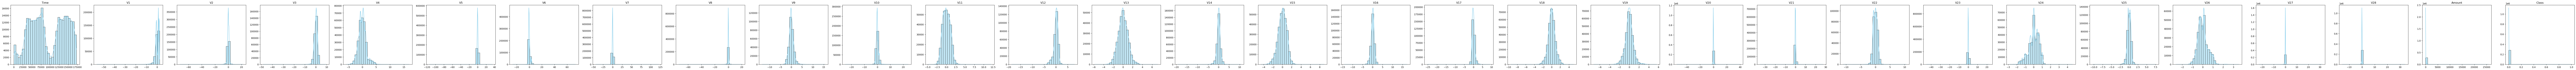

In [15]:
# Time is safe but Amount? That is a huge amount. Let us use RobustScaler since it is better for this situation (or so I was told, let us find out)
# Select numeric features
num_cols = df.select_dtypes(include=['number']).columns

# Set up subplots (adjust rows/cols depending on how many features you have)
n_cols = df.shape[1]  # number of plots per row
n_rows = int(len(num_cols) / n_cols) + 1

plt.figure(figsize=(n_cols * 5, n_rows * 4))

for i, col in enumerate(num_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(df[col], kde=True, bins=30, color="skyblue")
    plt.title(col)
    plt.xlabel("")
    plt.ylabel("")

plt.tight_layout()
plt.show()


In [16]:
# Let us standardize the amount and time columns
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1, 1))

# Drop the original Time and Amount columns
df.drop(['Time', 'Amount'], axis=1, inplace=True)

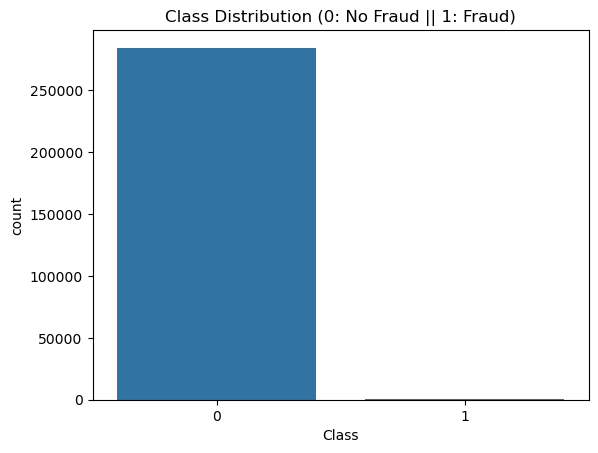

In [17]:
# We did this earlier but I want to see this in a plot
sns.countplot(x='Class', data=df)
plt.title('Class Distribution (0: No Fraud || 1: Fraud)')
plt.show()

# Very impressive, huh? :)

- Let us see how balance those. In the Loan Prediction repo (link: ), we tried to use SMOTE for a more intelligent and robust upsampling for minority classes. Now, Based on my research, here are the possible ways to balance the set or approach this problem:
    - Use Sampling (Under or Over sampling). Candidates can be SMOTE, Random, or even ADASYN (variant of SMOTE)
    - Approach it from a model perspective, candidates that can, supposedly deal with this imbalance case in a competent way are Isolation Forest, One-Class SVMs, or Autoencoders
    - Hybrid of the last two.

- If you took a look at the previous works, I think you may have noticed that I love to mix things. But here, I will test some different approachs in this project 

In [ ]:
# Let us 

In [ ]:
# Want to see the correlation matrix